<a href="https://colab.research.google.com/github/RusMermaid/Data_science_course_teaching/blob/main/L1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
#Hello
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.4 MB/s 


In [ ]:
!pip install scikit-learn
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 40.0 MB/s 
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [ ]:
# baseline cnn model for mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD, Adam
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

# define cnn model
def define_model():
  #  model = Sequential()
  #  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  #  model.add(MaxPooling2D((2, 2)))
  #  model.add(Flatten())
  #  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  #  model.add(Dense(10, activation='softmax'))
    # compile model
 #   opt = SGD(lr=0.01, momentum=0.9)
 #   model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  model = Sequential()
    
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(84, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  adam = Adam(lr=5e-4)
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

  #      self.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD')
  return model

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.rcParams['figure.figsize'] = (50,50)
#mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

#%tensorflow_version 1.x
import tensorflow as tf

from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
from tensorflow.keras.utils import load_img
#from keras.preprocessing.image import load_img

import tensorflow as tf

def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)


def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def get_model():
  """ Creates our model with access to intermediate layers. 
  
  This function will load the VGG19 model and access the intermediate layers. 
  These layers will then be used to create a new model that will take input image
  and return the outputs from these intermediate layers from the VGG model. 
  
  Returns:
    returns a keras model that takes image inputs and outputs the style and 
      content intermediate layers. 
  """
  # Load our model. We load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  # Get output layers corresponding to style and content layers 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model 
  return models.Model(vgg.input, model_outputs)

def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

def gram_matrix(input_tensor):
  # We make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  """Expects two images of dimension h, w, c"""
  # height, width, num filters of each layer
  # We scale the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

def get_feature_representations(model, content_path, style_path):
  """Helper function to compute our content and style feature representations.

  This function will simply load and preprocess both the content and style 
  images from their path. Then it will feed them through the network to obtain
  the outputs of the intermediate layers. 
  
  Arguments:
    model: The model that we are using.
    content_path: The path to the content image.
    style_path: The path to the style image
    
  Returns:
    returns the style features and the content features. 
  """
  # Load our images in 
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  
  # batch compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  
  # Get the style and content feature representations from our model  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  """This function will compute the loss total loss.
  
  Arguments:
    model: The model that will give us access to the intermediate layers
    loss_weights: The weights of each contribution of each loss function. 
      (style weight, content weight, and total variation weight)
    init_image: Our initial base image. This image is what we are updating with 
      our optimization process. We apply the gradients wrt the loss we are 
      calculating to this image.
    gram_style_features: Precomputed gram matrices corresponding to the 
      defined style layers of interest.
    content_features: Precomputed outputs from defined content layers of 
      interest.
      
  Returns:
    returns the total loss, style loss, content loss, and total variational loss
  """
  style_weight, content_weight = loss_weights
  
  # Feed our init image through our model. This will give us the content and 
  # style representations at our desired layers. Since we're using eager
  # our model is callable just like any other function!
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

import IPython.display
def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
  # We don't need to (or want to) train any layers of our model, so we set their
  # trainable to false. 
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # Get the style and content feature representations (from our specified intermediate layers) 
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Set initial image
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
 # opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)
  opt = tf.compat.v1.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)
 # opt = tf.optimizers.Adam(learning_rate=5, beta1=0.99, epsilon=1e-1)

  # For displaying intermediate images 
  iter_count = 1
  
  # Store our best result
  best_loss, best_img = float('inf'), None
  
  # Create a nice config 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  
  print('before loop')
  for i in range(num_iterations):
 #   print('start compute_grads ')
    grads, all_loss = compute_grads(cfg)
    
    loss, style_score, content_score = all_loss
    
 #   print('start apply_gradients')
    opt.apply_gradients([(grads, init_image)])
    
 #   print('start clip_by_value')
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    
    init_image.assign(clipped)
    end_time = time.time() 
    
 #   print(' before ifs')
    if loss < best_loss:
  #    print('in if loss < best_loss')
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      print('in if i % display_interval== 0:')
      start_time = time.time()
      
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
        
 #   print('go to next iter = ', i+1)

  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
        
  
      
  return best_img, best_loss




def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()



Попробуем предсказать пол человека по параметрам измерений его тела

In [ ]:
df = pd.read_csv('height_weight_waist_hips_gend.csv', header=0, index_col=0)
df = df.dropna()  

FileNotFoundError: ignored

In [ ]:
df.head(5)

Мы видим, что наши данные представляют собой таблицу, где каждая строчка - измерения конкретного человека:

его рост в мм, 

вес в кг, 

объем талии в мм, 

объем бедер в мм. 

В последней колонке стоит пол человека. 

0 - мужчина, 1 - женщина

вот наши факторы (признаки) на которых будет учиться модель:

In [ ]:
len(df)

772

Давайте ее научим:

In [ ]:
x_features = ['height_mm', 'weight','waist', 'hips']
from catboost import CatBoostClassifier
ctb = CatBoostClassifier(random_seed=17)
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

train_df_cat, y_train = train_df.drop("gender", axis=1), train_df['gender']
test_df_cat, y_test = test_df.drop("gender", axis=1), test_df['gender']

train_df_cat = train_df_cat[x_features]
test_df_cat = test_df_cat[x_features]

from catboost import CatBoostClassifier, Pool
gender_binary_model = CatBoostClassifier(random_seed=17, verbose=False)

gender_binary_model.fit(train_df_cat, y_train)


И проверим, как она работает, например на мне:

Мой рост 1650 мм

вес 65 гг

талия 750 мм

бедра 1000 мм

In [ ]:
x_features_my = [1650, 65,750, 1000]
g = gender_binary_model.predict_proba(x_features_my)
print('вы мужчина с вероятностью - ', g[0]*100, '%')
print('вы  женщина с вероятностью - ', g[1]*100, '%')

In [ ]:
x_features_my = [1600, 62,760, 950]
g = gender_binary_model.predict_proba(x_features_my)
print('вы мужчина с вероятностью - ', g[0]*100, '%')
print('вы  женщина с вероятностью - ', g[1]*100, '%')

NameError: ignored

Теперь посмотрим, как искусственный интеллект может распознавать рукописные цифры.

Загрузим данные, это картинки.

И посмотрим, как они выглядят.

11490434/11490434 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


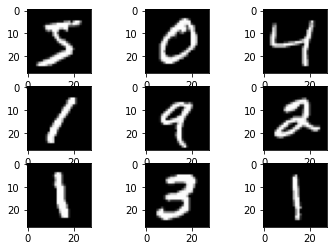

In [ ]:
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))

А вот как выглядит одна картинка для компьютерной программы. Видно что картинка - набор тех же чисел, где каждое число - значение яркости пиксела на соответствующем месте картинки.

In [ ]:
trainX[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

Итак, у нас 60000 картинок с рукописными цифрами от 1 до 9.

Признаки представляют собой числа - яркости пикселов.

А ответы - названия цифр.

Построим модель и научим ее на наших данных.

Модель учится не очень быстро. Пока она будет учиться, давайте пойдем в Paint и нарисуем несколько цифр, чтобы протестировать модель на наших собственных картинках.

In [ ]:
# load dataset
trainX, trainY, testX, testY = load_dataset()
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)

model = define_model()
# select rows for train and test

# fit model
model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=1)
# evaluate model
_, acc = model.evaluate(testX, testY, verbose=0)
print('> %.3f' % (acc * 100.0))

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
1875/1875 [==============================] - 16s 4ms/step - loss: 0.1393 - accuracy: 0.9579 - val_loss: 0.0453 - val_accuracy: 0.9853
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0427 - accuracy: 0.9869 - val_loss: 0.0275 - val_accuracy: 0.9908
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0298 - accuracy: 0.9905 - val_loss: 0.0331 - val_accuracy: 0.9892
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0210 - accuracy: 0.9933 - val_loss: 0.0281 - val_accuracy: 0.9906
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0177 - accuracy: 0.9942 - val_loss: 0.0240 - val_accuracy: 0.9930
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0130 - accuracy: 0.9956 - val_loss: 0.0312 - val_accuracy: 0.9907
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0103 - accuracy: 0.9969 - val_loss: 0.0244 - val_accurac

Возьмем теперь несколько наших собственных картинок и протестируем модель

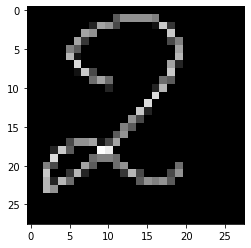

In [ ]:
import cv2
image = cv2.imread('2.jpg', cv2.IMREAD_GRAYSCALE) #
#image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
dim = (28, 28)
  
# resize image
image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
plt.imshow(image, cmap=plt.get_cmap('gray'))

In [ ]:
import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config
import numpy as np

np_config.enable_numpy_behavior()
image_norm = image.astype('float32')
image_norm = image_norm / 255.0

image_norm = tf.expand_dims(image, axis=-1)
image_norm = tf.expand_dims(image_norm, axis=-1)

#image_norm = image_norm.eval(session=tf.Session())
#image_norm = image_norm.numpy()
image_norm = image_norm.reshape(1, 28, 28, 1)
pred = model.predict(image_norm, batch_size=1) #.reshape(1, 28, 28, 1), batch_size=1)
print('прочитана цифра ', np.argmax(pred))


1/1 [==============================] - 0s 134ms/step
прочитана цифра  2


Следующий пример более творческий.

Давайте попросим модель смешать стили разных картинок.

In [ ]:
#tf.enable_eager_execution()
#print("Eager execution: {}".format(tf.executing_eagerly()))

Давайте загрузим 2 картинки и посмотрим на них

In [ ]:
from pylab import *

Посмотрим, что получится, если добавить в 1ю картинку немного стиля из второй

In [ ]:
import cv2



In [ ]:
plt.figure(figsize=(10,10))

content = load_img('11.jpg').astype('uint8')
style = load_img('29.jpg').astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()



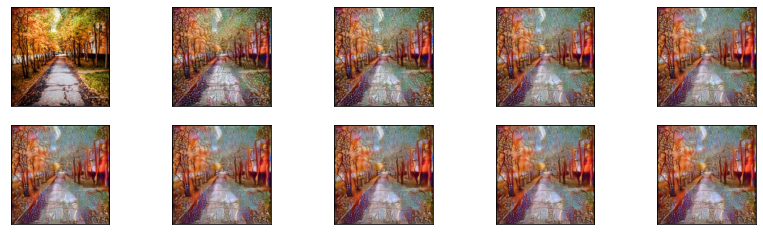

In [ ]:
best, best_loss = run_style_transfer('11.jpg', '29.jpg')



ValueError: ignored

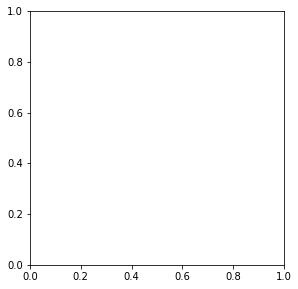

In [ ]:
show_results(best, '11.jpg', '29.jpg', show_large_final=True)